<a href="https://colab.research.google.com/github/NadiaHolmlund/Semester_Project/blob/main/Facial_Emotion_Recognition_(FER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Recognition (FER) with the Vision Transformer (ViT) by Gogle Brain

The following notebook contains the fine-tuning process of a pre-trained vision transformer (ViT) on the FER2013 dataset. The [dataset]((https://www.kaggle.com/datasets/deadskull7/fer2013).) is a collection of 35.887 48x48 grayscale images in 7 classes (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral). The training set consists of 28.709 images while the validation and test sets consist of 3.589 images.

The Vision Transformer (ViT) is similar to BERT, but rather than text the ViT has been trained on images. According to the [paper](https://arxiv.org/abs/2010.11929) on ViT, it attains excellent results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train

In the notebook, the data is prepared using 🤗 [datasets](https://github.com/huggingface/datasets) and the model is trained using the 🤗 [Trainer](https://huggingface.co/transformers/main_classes/trainer.html).

The process is inspired by a tutorial by Niels Rogge, ML engineer at 🤗 [HuggingFace](https://huggingface.co'), who fine-tuned ViT on the CIFAR-10 dataset using HugginFace's [Trainer](https://huggingface.co/transformers/main_classes/trainer.html). The tutorial can be found [here](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/VisionTransformer).

# Imports

In [ ]:
# Pip installs
!pip install -q transformers==4.28.0 # Version 4.28.0 is installed to circumvent an issue with accelerator and the introduction of Partial State in later versions
!pip install -q transformers datasets
!pip install accelerate -U -q

In [ ]:
# Libraries
from datasets import *
from transformers import ViTFeatureExtractor
from transformers import ViTModel
from transformers import TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd 
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Loading the dataset



Due to the size of the dataset (301MB) it exceeds the file-size limit on Github, hence it is loaded from Google Drive (requires personal access).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/FER2013"

In [ ]:
%cd /content/gdrive/My Drive/FER2013

/content/gdrive/My Drive/FER2013


In [ ]:
#!kaggle datasets download -d deadskull7/fer2013

In [ ]:
#!unzip \*.zip  && rm *.zip

In [ ]:
fer_df = pd.read_csv("/content/gdrive/MyDrive/FER2013/fer2013.csv")  # available on kaggle

In [ ]:
fer_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
fer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


# Preprocessing

In [ ]:
# Defining the labels for emotions in the dataset
string_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

In [ ]:
# Importing the ViT Feature Extractor from HuggingFace
# The Feature Extractor resizes every image to the resolution that the model expects, i.e. 224x224, and normalizes the channels
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


First preprocessing step

In [ ]:
def prepare_fer_data(data):
    """ Prepare fer data for vision transformer 
        input: fer df loaded from csv
        output: df that can be load into a huggingface dataset """

    # outputs
    image_list = []
    image_labels = list(map(int, data['emotion']))
    
    # go over all images
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        # adapt grayscale to rgb format (change single values to triplets of the same value)
        image = image[..., np.newaxis]
        image = np.repeat(image, 3, axis=2)
        # convert to list format used by the later functions
        image = image.astype(int).tolist()
        # save to output
        image_list.append(image)

    output_df = pd.DataFrame(list(zip(image_list, image_labels)),
               columns =['img', 'label'])
        
    return output_df

In [ ]:
fer_train_df = prepare_fer_data(fer_df[fer_df['Usage']=='Training'].sample(n = 500))
fer_test_df = prepare_fer_data(fer_df[fer_df['Usage']=='PrivateTest'].sample(n = 50))
fer_val_df = prepare_fer_data(fer_df[fer_df['Usage']=='PublicTest'].sample(n = 50))

In [ ]:
fer_train_df.head()

,img,label
0,"[[[0, 0, 0], [1, 1, 1], [1, 1, 1], [0, 0, 0], ...",6
1,"[[[71, 71, 71], [40, 40, 40], [39, 39, 39], [6...",6
2,"[[[32, 32, 32], [25, 25, 25], [19, 19, 19], [5...",0
3,"[[[156, 156, 156], [166, 166, 166], [193, 193,...",3
4,"[[[152, 152, 152], [151, 151, 151], [151, 151,...",2


In [ ]:
print(len(fer_train_df))
print(len(fer_test_df))
print(len(fer_val_df))

500
50
50


In [ ]:
train_ds = Dataset.from_pandas(fer_train_df)
val_ds = Dataset.from_pandas(fer_val_df)
test_ds = Dataset.from_pandas(fer_test_df)

print(train_ds)
print(val_ds)
print(test_ds)

Dataset({
    features: ['img', 'label'],
    num_rows: 500
})
Dataset({
    features: ['img', 'label'],
    num_rows: 50
})
Dataset({
    features: ['img', 'label'],
    num_rows: 50
})


In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

500
50
50


In [ ]:
# image size 
np.array(train_ds[0]["img"]).shape

(48, 48, 3)

Second preprocessing step using the ViT feature extractor

In [ ]:
def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [ ]:
# features of the new dataset with an additional column for the preprocess 224x224x3 images 
features = Features({
    'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']),
    'img': Array3D(dtype="int64", shape=(3,48,48)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, batch_size=1, features=features)
with open('preprocessed_train_ds.pickle', 'wb') as handle:
    pickle.dump(preprocessed_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_val_ds.pickle', 'wb') as handle:
    pickle.dump(preprocessed_val_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_test_ds.pickle', 'wb') as handle:
    pickle.dump(preprocessed_test_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

preprocessed_train_ds

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'img', 'pixel_values'],
    num_rows: 500
})

In [ ]:
# final image size
print(len(preprocessed_train_ds[0]["pixel_values"]))       
print(len(preprocessed_train_ds[0]["pixel_values"][0]))     
print(len(preprocessed_train_ds[0]["pixel_values"][0][0]))  

3
224
224


## Examining the data

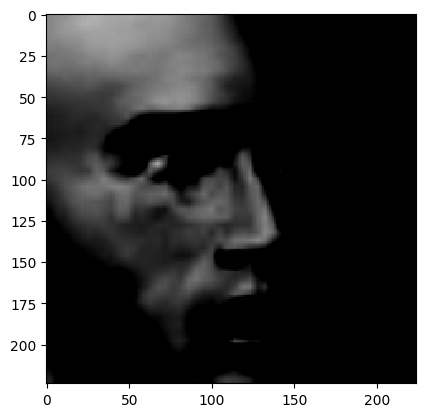

Surprise


In [ ]:
# show a single image from the dataset
data_for_image = np.array(preprocessed_train_ds[0]["pixel_values"])
data_for_image[data_for_image < 0] = 0 

plt.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
plt.show()

print(string_labels[preprocessed_train_ds[0]["label"]])

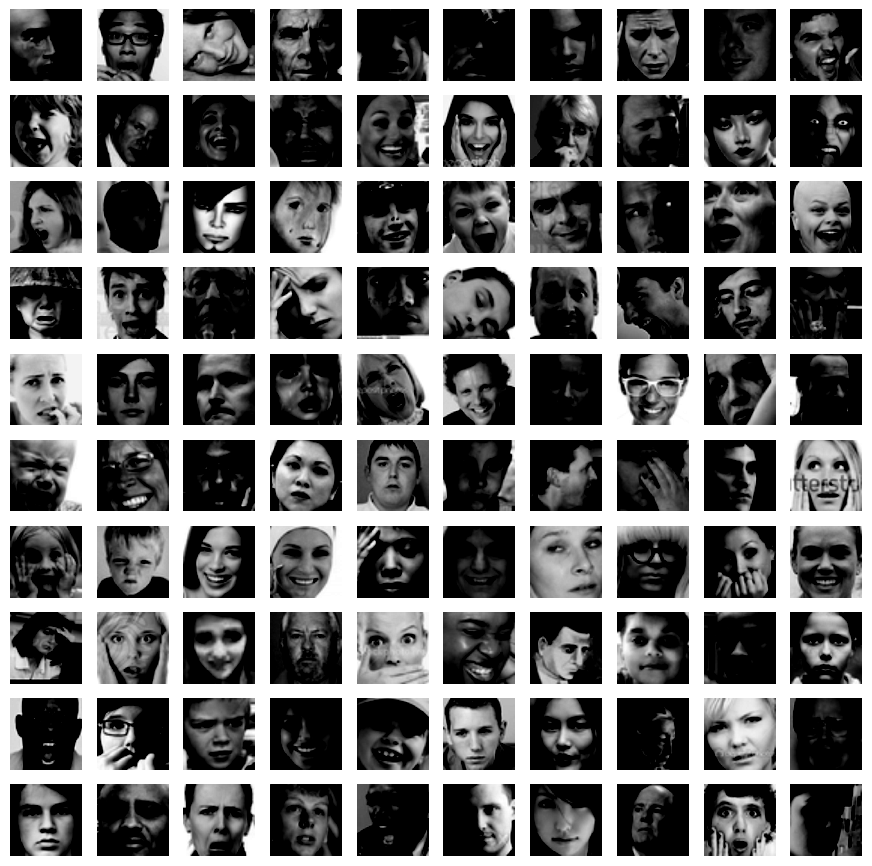

In [ ]:
# show 100 images from the dataset
fig, axes = plt.subplots(10,10, figsize=(11,11))
for i,ax in enumerate(axes.flat):
  data_for_image = np.array(preprocessed_train_ds[i]["pixel_values"])
  data_for_image[data_for_image < 0] = 0 
  ax.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
  ax.set_axis_off()


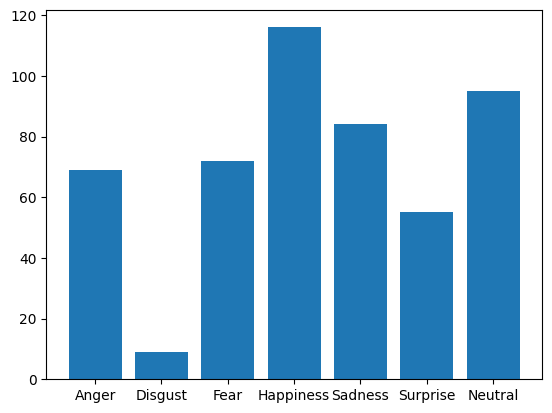

In [ ]:
# distribution of labels in the training set
keys, counts = np.unique(preprocessed_train_ds["label"], return_counts=True)
plt.bar(string_labels, counts)
plt.show()

## Defining the model

The model architecture is defined in PyTorch, with dropout and a linear layer added on top of the ViT model's output of the special CLS token representing the input picture. 


In [ ]:
class ViTForImageClassification(nn.Module):
    #define architecture
    def __init__(self, num_labels=len(string_labels)):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

Training uses the standard HuggingFace [Trainer](https://huggingface.co/transformers/main_classes/trainer.html) interface. 

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    f"test_FER2013",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
)

In [ ]:
import os

folder_name = "Model"
folder_path = os.path.join(os.getcwd(), folder_name)

print("Folder path:", folder_path)

Folder path: /content/Model


In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-25-e0422430864c>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
model = ViTForImageClassification()

In [ ]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = preprocessed_train_ds,
    eval_dataset = preprocessed_val_ds,
    compute_metrics = compute_metrics,
)

## Fine-tuning ViT


Fine-tuning the model by calling the `train()` method

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.798912,0.400000
2,No log,1.686518,0.420000
3,No log,1.608550,0.460000
4,No log,1.553648,0.440000
5,No log,1.516110,0.440000
6,No log,1.507802,0.440000


TrainOutput(global_step=192, training_loss=1.5405826568603516, metrics={'train_runtime': 3124.2041, 'train_samples_per_second': 0.96, 'train_steps_per_second': 0.061, 'total_flos': 0.0, 'train_loss': 1.5405826568603516, 'epoch': 6.0})

## Evaluation on Test Set

The test score after fine-tuning

In [ ]:
outputs = trainer.predict(preprocessed_test_ds)
print(outputs.metrics)

{'test_loss': 1.5547481775283813, 'test_accuracy': 0.5, 'test_runtime': 16.8763, 'test_samples_per_second': 2.963, 'test_steps_per_second': 0.237}


The results on the test set as confusion matrix

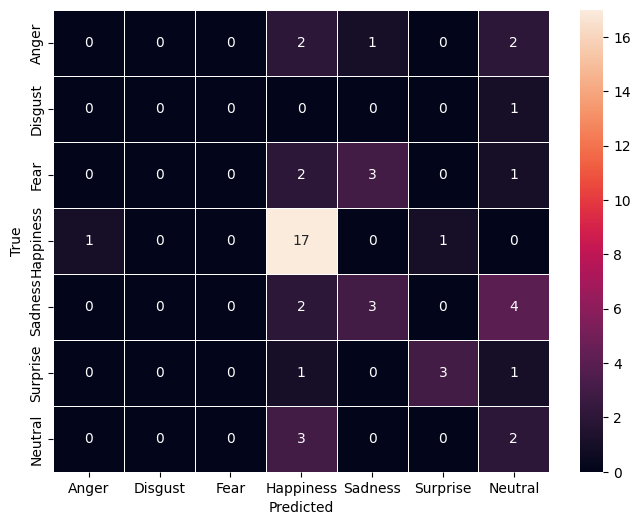

In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
fig, ax = plt.subplots(figsize=(8,6))  
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=string_labels, yticklabels=string_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()